# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

was way to hot for my blood, took a bite and did a jig  lol


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

was way to hot for my blood took a bite and did a jig lol


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in final['Text'].values:
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

In [23]:
preprocessed_reviews[1500]

'way hot blood took bite jig lol'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [24]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_summary = []
# tqdm is for printing the status bar
for sentance in final['Summary'].values:
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_summary.append(sentance.strip())

# [4] Featurization

## [4.1] BAG OF WORDS

In [25]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaaaa', 'aaaaaaahhhhhh', 'aaaaaaarrrrrggghhh', 'aaaaaawwwwwwwwww', 'aaaaah']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (87773, 54904)
the number of unique words  54904


## [4.2] Bi-Grams and n-Grams.

In [0]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.3] TF-IDF

In [0]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able find', 'able get', 'absolute', 'absolutely', 'absolutely delicious', 'absolutely love', 'absolutely no', 'according']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.4] Word2Vec

In [71]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [26]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('awesome', 0.8489307761192322), ('fantastic', 0.846041738986969), ('good', 0.8304756879806519), ('terrific', 0.8221842050552368), ('excellent', 0.7940770387649536), ('wonderful', 0.7803968191146851), ('amazing', 0.7630211114883423), ('perfect', 0.7599931359291077), ('fabulous', 0.7363346815109253), ('nice', 0.7196016311645508)]
[('greatest', 0.807036280632019), ('coolest', 0.7524900436401367), ('tastiest', 0.7455837726593018), ('nastiest', 0.7258838415145874), ('best', 0.7224494218826294), ('disgusting', 0.6559969186782837), ('awful', 0.6143525838851929), ('cry', 0.6111154556274414), ('worse', 0.609216570854187), ('closest', 0.6075185537338257)]


In [27]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  17386
sample words  ['obscure', 'chili', 'grandaughter', 'organizations', 'panarello', 'definately', 'skin', 'thumb', 'huey', 'patak', 'urging', 'subcribe', 'amounts', 'boba', 'pasture', 'tiresome', 'collins', 'suppliers', 'r', 'chomping', 'tab', 'measure', 'fading', 'previously', 'grabers', 'immature', 'garnish', 'casing', 'curries', 'mug', 'justify', 'stacy', 'delectable', 'festive', 'slivers', 'repeated', 'lite', 'widely', 'rotating', 'mingle', 'solidly', 'salut', 'marine', 'relax', 'tic', 'mezzetta', 'cookie', 'preparation', 'problem', 'filtration']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [0]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:03<00:00, 1330.47it/s]


4986
50


#### [4.4.1.2] TFIDF weighted W2v

In [28]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [0]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:20<00:00, 245.63it/s]


In [25]:
# Function to plot confusion matrix
def confusion_matrix_plot(test_y, predict_y):
    # C stores the confusion matrix 
    C = confusion_matrix(test_y, predict_y)
    
    
    # Class labels 
    labels_x = ["Predicted No","Predicted Yes"]
    labels_y = ["Original No","Original Yes"]
    
    cmap=sns.light_palette("orange")
    plt.figure(figsize=(4,4))
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels_x, yticklabels=labels_y)
    plt.title("Confusion Matrix")
    plt.show()

In [26]:
# Function to plot roc curve

def plot_roc_curve(Y_test,predict_y_test,Y_train,predict_y_train):
    plt.figure(figsize=(10,5))
    fpr1,tpr1,threshold1 = roc_curve(Y_test,predict_y_test) # For test dataset
    fpr2,tpr2,threshold2 = roc_curve(Y_train,predict_y_train) # For train dataset
    
    plt.plot([0,1],[0,1])
    plt.plot(fpr1,tpr1,label="Test AUC")
    plt.plot(fpr2,tpr2,label="Train AUC")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc = 'lower right')
    plt.title("Reciever Operating Characteristic")
    plt.grid()
    plt.show()

In [27]:
import math
# Plotting graph of auc and parameter for training and cross validation error
alpha = [1,5,10,50,100,500,1000]
alpha = [math.log10(x) for x in alpha]
def plot_train_vs_auc(train_auc_list,cv_auc_list):
    plt.plot(alpha,train_auc_list,label="Train AUC")
    plt.xlabel("log of Hyper-parameter alpha")
    plt.ylabel("Area Under Curve")
    plt.plot(alpha,cv_auc_list,label="Validation AUC")
    plt.legend()
    plt.show()

In [28]:
def plot_train_auc_heatmap(C):
    labels_y =['1','5','10','50','100','500','1000']
    labels_x= ['5','10','100','500']
    
    cmap=sns.light_palette("orange")
    plt.figure(figsize=(4,7))
    plt.xlabel("Min Sample Splits")
    plt.ylabel("Depth of Tree")
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels_x, yticklabels=labels_y)
    plt.xlabel("Min Samples Split")
    plt.ylabel("Max Tree Depth")
    plt.title("AUC for train dataset")
    plt.show()
    

In [29]:
def plot_cv_auc_heatmap(C):
    labels_y =['1','5','10','50','100','500','1000']
    labels_x= ['5','10','100','500']
    
    cmap=sns.light_palette("orange")
    plt.figure(figsize=(4,7))
    plt.xlabel("Min Sample Splits")
    plt.ylabel("Depth of Tree")
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels_x, yticklabels=labels_y)
    plt.xlabel("Min Samples Split")
    plt.ylabel("Max Tree Depth")
    plt.title("AUC for CV dataset")
    plt.show()
    

# [5] Assignment 8: Decision Trees

<ol>
    <li><strong>Apply Decision Trees on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning (best `depth` in range [1, 5, 10, 50, 100, 500, 100], and the best `min_samples_split` in range [5, 10, 100, 500])</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Graphviz</strong>
        <ul>
    <li>Visualize your decision tree with Graphviz. It helps you to understand how a decision is being made, given a new vector.</li>
    <li>Since feature names are not obtained from word2vec related models, visualize only BOW & TFIDF decision trees using Graphviz</li>
    <li>Make sure to print the words in each node of the decision tree instead of printing its index.</li>
    <li>Just for visualization purpose, limit max_depth to 2 or 3 and either embed the generated images of graphviz in your notebook, or directly upload them as .png files.</li>                
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Find the top 20 important features from both feature sets <font color='red'>Set 1</font> and <font color='red'>Set 2</font> using `feature_importances_` method of <a href='https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html'>Decision Tree Classifier</a> and print their corresponding feature names</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Decision Trees

## [5.1] Applying Decision Trees on BOW,<font color='red'> SET 1</font>

In [30]:
import warnings
warnings.filterwarnings('ignore',category=DeprecationWarning)
warnings.filterwarnings('ignore',category=FutureWarning)

In [31]:
# Initializing BagOfWords
bow_vect = CountVectorizer()

X = preprocessed_reviews
Y = final['Score']

from sklearn.cross_validation import train_test_split
from sklearn.model_selection import TimeSeriesSplit

# Splitting data into train and test
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.3,random_state=42)
print(len(X_train))
print(len(X_test))

61441
26332


In [32]:
# Vectorizing train and test data seperately
bow_train_vect = bow_vect.fit_transform(X_train)
bow_test_vect = bow_vect.transform(X_test)
print(bow_train_vect.shape)
print(bow_test_vect.shape)

(61441, 46115)
(26332, 46115)


In [33]:
# Standarizing data
from sklearn.preprocessing import StandardScaler
std = StandardScaler(with_mean=False)
bow_train_vect = std.fit_transform(bow_train_vect)
bow_test_vect = std.fit_transform(bow_test_vect)

In [34]:
# Defining hyper-parameter values
depth = [1,5,10,50,100,500,1000]
splits = [5,10,100,500]

In [35]:
# Matrix which will store the AUC value at each of the combination possible with the above 2 hyper parameters.
import numpy as np
train_auc_mat = np.zeros(shape=(len(depth),len(splits)))
print(train_auc_mat)

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


In [36]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score


i=0 # To keep count of row in Auc_mat.
j=0 # To keep count of col in Auc_mat.
for k in tqdm(depth):
    j=0 # For each row initialize the col to zero. and then it will get increased with each iteration.
    for s in splits:
        clf = DecisionTreeClassifier(max_depth= k,min_samples_split=s)
    
        # Trainig our model
        clf.fit(bow_train_vect,Y_train)
    
        predict_probab = clf.predict_proba(bow_train_vect)[:,1] # Returns probability for positive class only
    
        auc = roc_auc_score(Y_train,predict_probab)
        train_auc_mat[i][j] = auc
        j = j+1  # Increase col number in each iter.
    
    i = i+1 # Increment the row number once each splits is checked for a particular depth
    

100%|██████████| 7/7 [10:05<00:00, 125.32s/it]


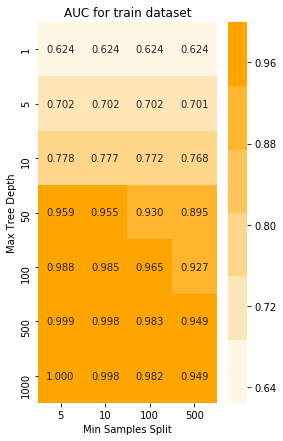

In [37]:
# Printing plot for AUC for train dataset.
plot_train_auc_heatmap(train_auc_mat)

In [38]:
# To store auc for cross validation .
test_auc_mat = np.zeros(shape=(len(depth),len(splits)))

In [39]:
# We will do time based splitting and do 5 fold cross validation 
# This is done as reviews keeps changing with time and hence time based splitting is required

from sklearn.model_selection import TimeSeriesSplit
# Time series object
tscv = TimeSeriesSplit(n_splits=5)

m=0 # To keep count of row in Auc_mat.
n=0 # To keep count of col in Auc_mat.
for k in tqdm(depth):
    n=0
    for s in splits:
        # Decision Tree classifier
        clf = DecisionTreeClassifier(max_depth= k,min_samples_split=s)
        i=0
        auc=0.0
        for train_index,test_index in tscv.split(bow_train_vect):
            x_train = bow_train_vect[0:train_index[-1]][:] # row 0 to train_index(excluding)
            y_train = Y_train[0:train_index[-1]][:] # row 0 to train_index(excluding)
            x_test = bow_train_vect[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
            y_test = Y_train[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
    
            clf.fit(x_train,y_train)
    
            predict_probab = clf.predict_proba(x_test)[:,1] # returns probability for positive points
            i += 1
            auc += roc_auc_score(y_test,predict_probab)
            
        test_auc_mat[m][n] = auc/i
        n = n+1 # Increment col number.
        
    m = m+1 # Increment row number
        
        

100%|██████████| 7/7 [21:23<00:00, 248.27s/it]


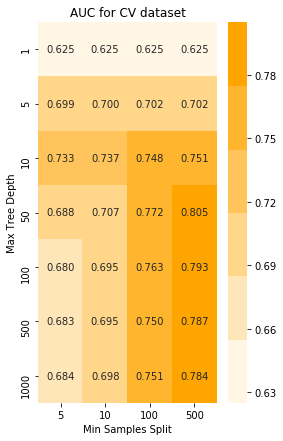

In [40]:
# Printing plot for AUC for test dataset.
plot_cv_auc_heatmap(test_auc_mat)

<h3>Using Grid Search CV</h3>

In [41]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score

# Selecting the estimator . Estimator is the model that you will use to train your model
# We will pass this instance to GridSearchCV
clf = DecisionTreeClassifier(class_weight="balanced")
# Dictionary of parameters to be searched on 
parameters = {'max_depth':depth,'min_samples_split':splits}

# Value on which model will be evaluated
auc_score = make_scorer(roc_auc_score)

# Calling GridSearchCV .
grid_model = GridSearchCV(estimator = clf,param_grid=parameters,cv=3,refit=True,scoring=auc_score,n_jobs=-1)

# Training the gridsearchcv instance
grid_model.fit(bow_train_vect,Y_train)

# this gives the best model with best hyper parameter
optimized_clf = grid_model.best_estimator_
#best_parameters = optimized_clf.best_params_
#best_split = grid_model.best_estimator_.min_samples_split

predict_probab = optimized_clf.predict_proba(bow_test_vect)[:,1] # returns probability of positive points
#predict_y_test = optimized_clf.predict(bow_test_vect)
#predict_y_train = optimized_clf.predict(bow_train_vect)


print("The optimized model is",optimized_clf)
print("AUC of best model is",roc_auc_score(Y_test,predict_probab))

The optimized model is DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=50, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=500,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
AUC of best model is 0.8115899072807418


In [42]:
print(grid_model.best_params_)

{'min_samples_split': 500, 'max_depth': 50}


In [43]:
# Now training model on the hyper parameter which gave best AUC
tree1 = DecisionTreeClassifier(max_depth=50,min_samples_split=500)
tree1.fit(bow_train_vect,Y_train)

# predict class for train dataset
train_y_predict = tree1.predict(bow_train_vect)
# Predict class for test dataset
test_y_predict = tree1.predict(bow_test_vect)

# class probability for train dataset
train_proba = tree1.predict_proba(bow_train_vect)[:,1] # returns probability for positive class
# Class probability for test dataset
test_proba = tree1.predict_proba(bow_test_vect)[:,1] # returns probability for positive class
print("AUC of Bow vectorized Decision Tree Classifier is {:.3f}".format(roc_auc_score(Y_test,test_proba)))

AUC of Bow vectorized Decision Tree Classifier is 0.834


Confusion Matrix for test data


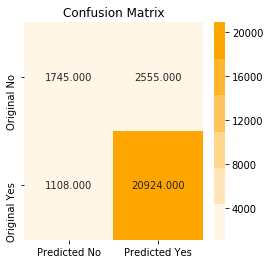

In [44]:
# Plotting confusion matrix
print("Confusion Matrix for test data")
confusion_matrix_plot(Y_test,test_y_predict)

Confusion Matrix for test data


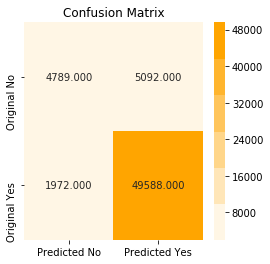

In [45]:
# Plotting confusion matrix
print("Confusion Matrix for test data")
confusion_matrix_plot(Y_train,train_y_predict)

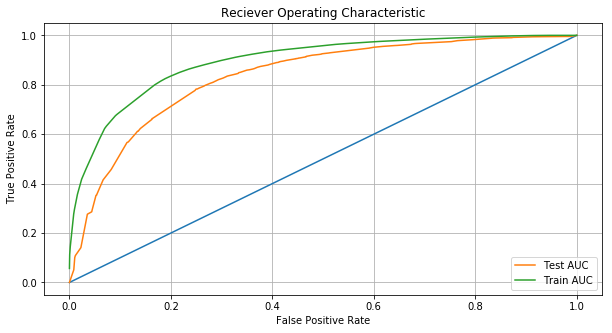

In [46]:
# Plotting ROC AUC curve
plot_roc_curve(Y_test,test_proba,Y_train,train_proba)

### [5.1.1] Top 20 important features from<font color='red'> SET 1</font>

Text(0.5, 1.0, 'Word Cloud Showing 20 most important features')

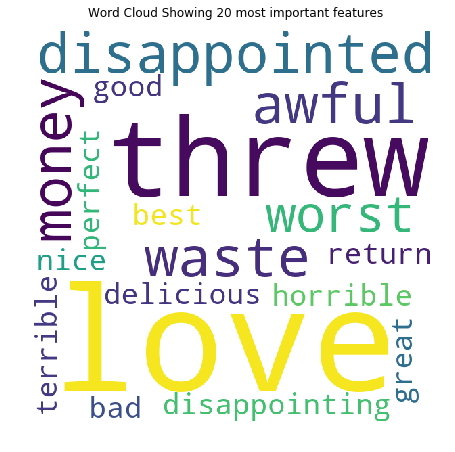

In [47]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 

stopwords = set(STOPWORDS)

# Getting all the feature names
all_feat = bow_vect.get_feature_names()
# Getting index of top 20 features.
top_20_feat_index = tree1.feature_importances_.argsort()[-20:]

top_20_feat = [all_feat[i] for i in top_20_feat_index]

feat_str = ' '
for wrd in top_20_feat:
    feat_str = feat_str + wrd + ' '



wordcloud = WordCloud(width = 600, height = 600, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 6).generate(feat_str)

# plot the WordCloud image                        
plt.figure(figsize = (6, 6), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title("Word Cloud Showing 20 most important features")
  

### [5.1.2] Graphviz visualization of Decision Tree on BOW,<font color='red'> SET 1</font>

In [34]:
# Limiting depth of tree to 3 for printing tree with graphviz
from sklearn.tree import DecisionTreeClassifier
graph_tree = DecisionTreeClassifier(max_depth=3,min_samples_split=500)
graph_tree.fit(bow_train_vect,Y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=500,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

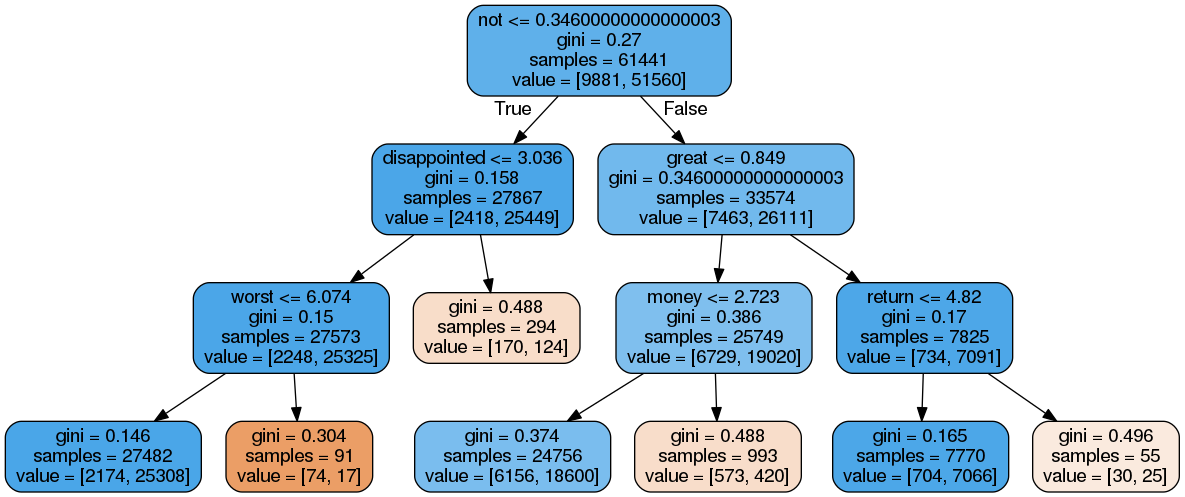

In [43]:
from sklearn import tree
from IPython.display import Image
from sklearn.externals.six import StringIO
from sklearn.tree import export_graphviz
import pydot
# Getting feature names
features = bow_vect.get_feature_names()

# Storing the classifier into dot file
dot_data = StringIO()
export_graphviz(graph_tree, out_file=dot_data,feature_names = features,filled=True,rounded=True)
graph = pydot.graph_from_dot_data(dot_data.getvalue())
Image(graph[0].create_png())

## [5.2] Applying Decision Trees on TFIDF,<font color='red'> SET 2</font>

In [44]:
# initializing TfidfVectorizer
tfidf_vect = TfidfVectorizer()

# Vectorizing train and test dataset
train_tfidf_vect = tfidf_vect.fit_transform(X_train)
test_tfidf_vect = tfidf_vect.transform(X_test)
print(train_tfidf_vect.shape)
print(test_tfidf_vect.shape)

(61441, 46115)
(26332, 46115)


In [45]:
# Standarizing data
from sklearn.preprocessing import StandardScaler
std = StandardScaler(with_mean=False)
train_tfidf_vect = std.fit_transform(train_tfidf_vect)
test_tfidf_vect = std.fit_transform(test_tfidf_vect)

In [56]:
# To find train AUC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score

i=0 # To keep count of row in Auc_mat.
j=0 # To keep count of col in Auc_mat.
for k in tqdm(depth):
    j=0 # For each row initialize the col to zero. and then it will get increased with each iteration.
    for s in splits:
        clf = DecisionTreeClassifier(max_depth= k,min_samples_split=s,class_weight='balanced')
    
        # Trainig our model
        clf.fit(train_tfidf_vect,Y_train)
    
        predict_probab = clf.predict_proba(train_tfidf_vect)[:,1] # Returns probability for positive class only
    
        auc = roc_auc_score(Y_train,predict_probab)
        train_auc_mat[i][j] = auc
        j = j+1  # Increase col number in each iter.
    
    i = i+1 # Increment the row number once each splits is checked for a particular depth

100%|██████████| 7/7 [11:07<00:00, 134.61s/it]


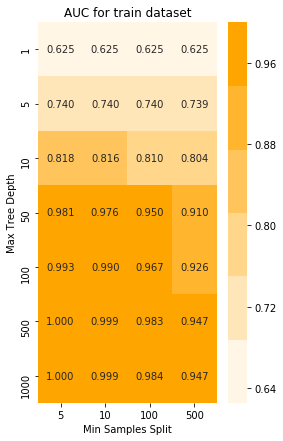

In [58]:
# Printing plot for AUC for train dataset.
plot_train_auc_heatmap(train_auc_mat)

In [59]:
# We will do time based splitting and do 10 fold cross validation 
# This is done as reviews keeps changing with time and hence time based splitting is required

from sklearn.model_selection import TimeSeriesSplit
# Time series object
tscv = TimeSeriesSplit(n_splits=10)

m=0 # To keep count of row in Auc_mat.
n=0 # To keep count of col in Auc_mat.
for k in tqdm(depth):
    n=0
    for s in splits:
        # Decision Tree classifier
        clf = DecisionTreeClassifier(max_depth= k,min_samples_split=s,class_weight='balanced')
        i=0
        auc=0.0
        for train_index,test_index in tscv.split(train_tfidf_vect):
            x_train = train_tfidf_vect[0:train_index[-1]][:] # row 0 to train_index(excluding)
            y_train = Y_train[0:train_index[-1]][:] # row 0 to train_index(excluding)
            x_test = train_tfidf_vect[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
            y_test = Y_train[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
    
            clf.fit(x_train,y_train)
    
            predict_probab = clf.predict_proba(x_test)[:,1] # returns probability for positive points
            i += 1
            auc += roc_auc_score(y_test,predict_probab)
            
        test_auc_mat[m][n] = auc/i
        n = n+1 # Increment col number.
        
    m = m+1 # Increment row number
        

100%|██████████| 7/7 [48:31<00:00, 563.99s/it]


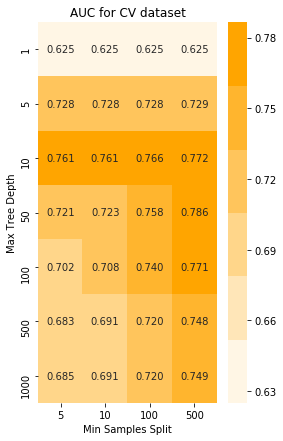

In [60]:
# Printing plot for AUC for test dataset.
plot_cv_auc_heatmap(test_auc_mat)

<h3>Using Grid Search CV</h3>

In [61]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score

# Selecting the estimator . Estimator is the model that you will use to train your model
# We will pass this instance to GridSearchCV
clf = DecisionTreeClassifier(class_weight="balanced")
# Dictionary of parameters to be searched on 
parameters = {'max_depth':depth,'min_samples_split':splits}

# Value on which model will be evaluated
auc_score = make_scorer(roc_auc_score)

# Calling GridSearchCV .
grid_model = GridSearchCV(estimator = clf,param_grid=parameters,cv=3,refit=True,scoring=auc_score,n_jobs=-1)

# Training the gridsearchcv instance
grid_model.fit(train_tfidf_vect,Y_train)

# this gives the best model with best hyper parameter
optimized_clf = grid_model.best_estimator_
#best_parameters = optimized_clf.best_params_
#best_split = grid_model.best_estimator_.min_samples_split

predict_probab = optimized_clf.predict_proba(test_tfidf_vect)[:,1] # returns probability of positive points
#predict_y_test = optimized_clf.predict(test_tfidf_vect)
#predict_y_train = optimized_clf.predict(train_tfidf_vect)


print("The optimized model is",optimized_clf)
print("AUC of best model is",roc_auc_score(Y_test,predict_probab))
print("Best Parameters are",grid_model.best_params_)

The optimized model is DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=50, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=500,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
AUC of best model is 0.8084679630896285
Best Parameters are {'min_samples_split': 500, 'max_depth': 50}


In [62]:
# Now training model on the hyper parameter which gave best AUC
tree2 = DecisionTreeClassifier(max_depth=50,min_samples_split=500)
tree2.fit(train_tfidf_vect,Y_train)

# predict class for train dataset
train_y_predict = tree2.predict(train_tfidf_vect)
# Predict class for test dataset
test_y_predict = tree2.predict(test_tfidf_vect)

# class probability for train dataset
train_proba = tree2.predict_proba(train_tfidf_vect)[:,1] # returns probability for positive class
# Class probability for test dataset
test_proba = tree2.predict_proba(test_tfidf_vect)[:,1] # returns probability for positive class
print("AUC of Tfidf vectorized Decision Tree Classifier is {:.3f}".format(roc_auc_score(Y_test,test_proba)))

AUC of Tfidf vectorized Decision Tree Classifier is 0.825


Confusion Matrix for test data


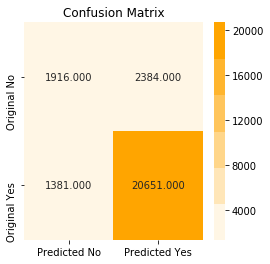

In [63]:
# Plotting confusion matrix
print("Confusion Matrix for test data")
confusion_matrix_plot(Y_test,test_y_predict)

Confusion Matrix for train data


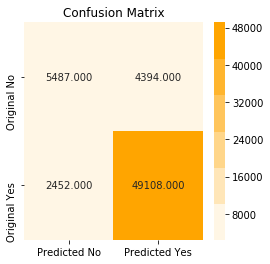

In [64]:
# Plotting confusion matrix
print("Confusion Matrix for train data")
confusion_matrix_plot(Y_train,train_y_predict)

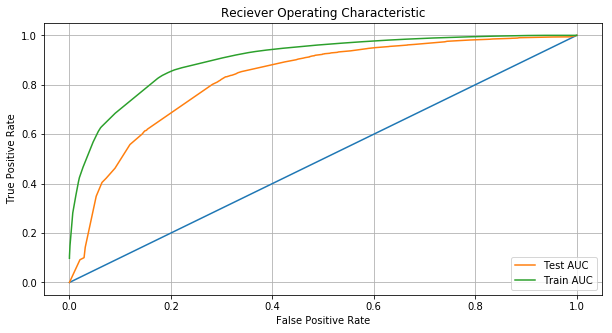

In [65]:
# Plotting ROC AUC curve
plot_roc_curve(Y_test,test_proba,Y_train,train_proba)

### [5.2.1] Top 20 important features from<font color='red'> SET 2</font>

Text(0.5, 1.0, 'Word Cloud Showing 20 most important features')

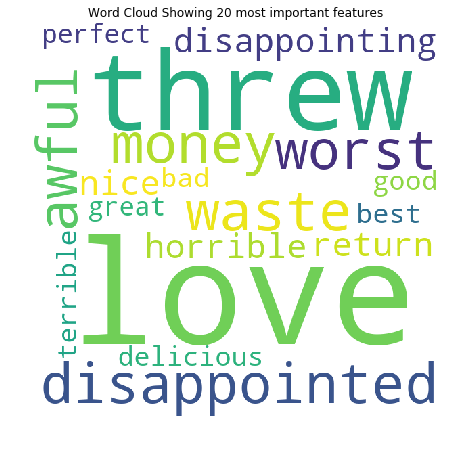

In [66]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 

stopwords = set(STOPWORDS)

# Getting all the feature names
all_feat = tfidf_vect.get_feature_names()
# Getting index of top 20 features.
top_20_feat_index = tree2.feature_importances_.argsort()[-20:]

top_20_feat = [all_feat[i] for i in top_20_feat_index]

feat_str = ' '
for wrd in top_20_feat:
    feat_str = feat_str + wrd + ' '



wordcloud = WordCloud(width = 600, height = 600, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 6).generate(feat_str)

# plot the WordCloud image                        
plt.figure(figsize = (6, 6), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title("Word Cloud Showing 20 most important features")
  

### [5.2.2] Graphviz visualization of Decision Tree on TFIDF,<font color='red'> SET 2</font>

In [46]:
# Training tree for graphviz
# Now training model on the hyper parameter which gave best AUC
graph_tree1 = DecisionTreeClassifier(max_depth=3,min_samples_split=500)
graph_tree1.fit(train_tfidf_vect,Y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=500,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

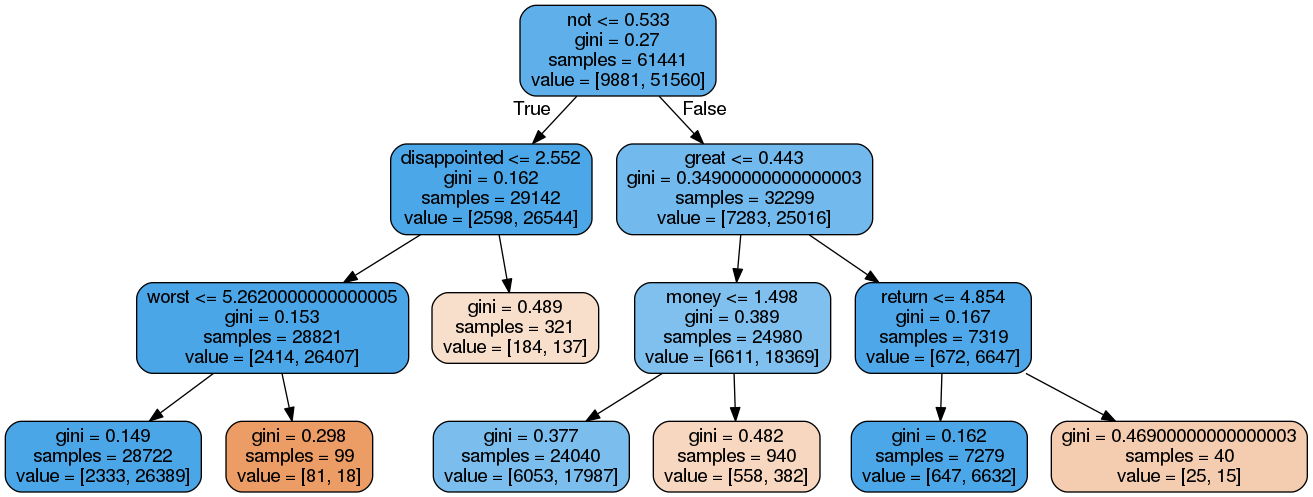

In [48]:
from sklearn import tree
from IPython.display import Image
from sklearn.externals.six import StringIO
from sklearn.tree import export_graphviz
import pydot
# Getting feature names
features = tfidf_vect.get_feature_names()

# Storing the classifier into dot file
dot_data1 = StringIO()
export_graphviz(graph_tree1, out_file=dot_data1,feature_names = features,filled=True,rounded=True)
graph1 = pydot.graph_from_dot_data(dot_data1.getvalue())
Image(graph1[0].create_png())

## [5.3] Applying Decision Trees on AVG W2V,<font color='red'> SET 3</font>

In [75]:
# Splitting data into train and test dataset
from sklearn.model_selection import train_test_split
Y = final['Score']
X_train,X_test,Y_train,Y_test = train_test_split(list_of_sentance,Y,test_size=0.3,random_state=42)

In [76]:
# Training word2Vec model on traain dataset and will use same for test dataset
is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(X_train,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('fantastic', 0.84521484375), ('awesome', 0.8343338966369629), ('good', 0.8172295093536377), ('excellent', 0.7936408519744873), ('terrific', 0.7897562384605408), ('wonderful', 0.7864882349967957), ('amazing', 0.7791675925254822), ('perfect', 0.7411020398139954), ('fabulous', 0.7104291319847107), ('incredible', 0.680510401725769)]
[('greatest', 0.753990888595581), ('best', 0.7164559364318848), ('closest', 0.6571850180625916), ('hottest', 0.6377782821655273), ('disgusting', 0.6249107122421265), ('tastiest', 0.6210892796516418), ('nastiest', 0.6125287413597107), ('smoothest', 0.6043229103088379), ('horrible', 0.6034840941429138), ('experienced', 0.5807958245277405)]


In [77]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  14819
sample words  ['pts', 'rustling', 'cotton', 'phenomenon', 'menadione', 'vegetarian', 'comprised', 'ramune', 'alternatives', 'alertness', 'ins', 'honeydew', 'oversight', 'shelter', 'bare', 'crashes', 'hopes', 'minicongos', 'bang', 'efficiently', 'frappes', 'operate', 'ribbons', 'vomit', 'decorative', 'success', 'escaping', 'teapot', 'saw', 'raisen', 'protected', 'illegal', 'bicarbonate', 'wave', 'snip', 'schmidt', 'froth', 'bored', 'mist', 'slits', 'turnip', 'bones', 'dents', 'tangy', 'bay', 'elsewhere', 'molars', 'must', 'expresso', 'insanity']


In [78]:
# average Word2Vec
# compute average word2vec for train dataset
train_sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(X_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    train_sent_vectors.append(sent_vec)
print(len(train_sent_vectors))
print(len(train_sent_vectors[0]))

100%|██████████| 61441/61441 [13:16<00:00, 77.11it/s] 

61441
50


In [79]:
# average Word2Vec
# compute average word2vec for test dataset.
test_sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(X_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    test_sent_vectors.append(sent_vec)
print(len(test_sent_vectors))
print(len(test_sent_vectors[0]))

100%|██████████| 26332/26332 [05:43<00:00, 76.72it/s] 

26332
50


In [80]:
# To find train AUC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score

i=0 # To keep count of row in Auc_mat.
j=0 # To keep count of col in Auc_mat.
for k in tqdm(depth):
    j=0 # For each row initialize the col to zero. and then it will get increased with each iteration.
    for s in splits:
        clf = DecisionTreeClassifier(max_depth= k,min_samples_split=s)
    
        # Trainig our model
        clf.fit(train_sent_vectors,Y_train)
    
        predict_probab = clf.predict_proba(train_sent_vectors)[:,1] # Returns probability for positive class only
    
        auc = roc_auc_score(Y_train,predict_probab)
        train_auc_mat[i][j] = auc
        j = j+1  # Increase col number in each iter.
    
    i = i+1 # Increment the row number once each splits is checked for a particular depth

100%|██████████| 7/7 [02:12<00:00, 21.84s/it]


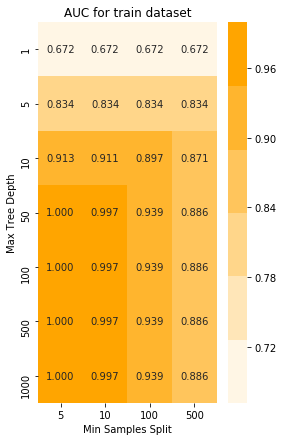

In [81]:
# Printing plot for AUC for train dataset.
plot_train_auc_heatmap(train_auc_mat)

In [82]:
# We will do time based splitting and do 10 fold cross validation 
# This is done as reviews keeps changing with time and hence time based splitting is required

from sklearn.model_selection import TimeSeriesSplit
# Time series object
tscv = TimeSeriesSplit(n_splits=5)

m=0 # To keep count of row in Auc_mat.
n=0 # To keep count of col in Auc_mat.
for k in tqdm(depth):
    n=0
    for s in splits:
        # Decision Tree classifier
        clf = DecisionTreeClassifier(max_depth= k,min_samples_split=s)
        i=0
        auc=0.0
        for train_index,test_index in tscv.split(train_sent_vectors):
            x_train = train_sent_vectors[0:train_index[-1]][:] # row 0 to train_index(excluding)
            y_train = Y_train[0:train_index[-1]][:] # row 0 to train_index(excluding)
            x_test = train_sent_vectors[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
            y_test = Y_train[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
    
            clf.fit(x_train,y_train)
    
            predict_probab = clf.predict_proba(x_test)[:,1] # returns probability for positive points
            i += 1
            auc += roc_auc_score(y_test,predict_probab)
            
        test_auc_mat[m][n] = auc/i
        n = n+1 # Increment col number.
        
    m = m+1 # Increment row number
        

100%|██████████| 7/7 [04:48<00:00, 47.14s/it]


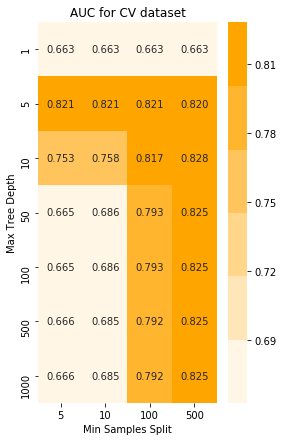

In [84]:
# Printing plot for AUC for test dataset.
plot_cv_auc_heatmap(test_auc_mat)

<h3>Using Grid Search CV</h3>

In [85]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score

# Selecting the estimator . Estimator is the model that you will use to train your model
# We will pass this instance to GridSearchCV
clf = DecisionTreeClassifier()
# Dictionary of parameters to be searched on 
parameters = {'max_depth':depth,'min_samples_split':splits}

# Value on which model will be evaluated
auc_score = make_scorer(roc_auc_score)

# Calling GridSearchCV .
grid_model = GridSearchCV(estimator = clf,param_grid=parameters,cv=3,refit=True,scoring=auc_score,n_jobs=-1)

# Training the gridsearchcv instance
grid_model.fit(train_sent_vectors,Y_train)

# this gives the best model with best hyper parameter
optimized_clf = grid_model.best_estimator_
#best_parameters = optimized_clf.best_params_
#best_split = grid_model.best_estimator_.min_samples_split

predict_probab = optimized_clf.predict_proba(test_sent_vectors)[:,1] # returns probability of positive points
#predict_y_test = optimized_clf.predict(test_sent_vectors)
#predict_y_train = optimized_clf.predict(train_sent_vectors)

auc = roc_auc_score(Y_test,predict_probab)
print("The optimized model is",optimized_clf)
print("Auc of best model is",auc)
print("Best Parameters are",grid_model.best_params_)

The optimized model is DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=500,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
Auc of best model is 0.6984349666869332
Best Parameters are {'min_samples_split': 10, 'max_depth': 500}


In [86]:
# Now training model on the hyper parameter which gave best AUC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
tree3 = DecisionTreeClassifier(max_depth=10,min_samples_split=10)
tree3.fit(train_sent_vectors,Y_train)

# predict class for train dataset
train_y_predict = tree3.predict(train_sent_vectors)
# Predict class for test dataset
test_y_predict = tree3.predict(test_sent_vectors)

# class probability for train dataset
train_proba = tree3.predict_proba(train_sent_vectors)[:,1] # returns probability for positive class
# Class probability for test dataset
test_proba = tree3.predict_proba(test_sent_vectors)[:,1] # returns probability for positive class
print("AUC of Avg W2V vectorized Decision Tree Classifier is {:.3f}".format(roc_auc_score(Y_test,test_proba)))

AUC of Avg W2V vectorized Decision Tree Classifier is 0.814


Confusion Matrix for test data


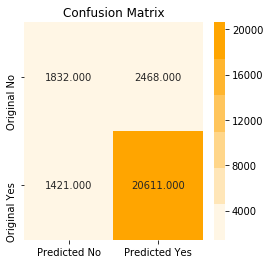

In [87]:
# Plotting confusion matrix
print("Confusion Matrix for test data")
confusion_matrix_plot(Y_test,test_y_predict)

Confusion Matrix for train data


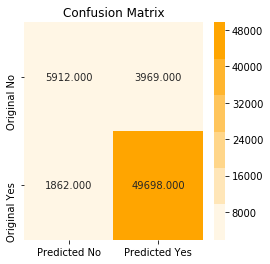

In [88]:
# Plotting confusion matrix
print("Confusion Matrix for train data")
confusion_matrix_plot(Y_train,train_y_predict)

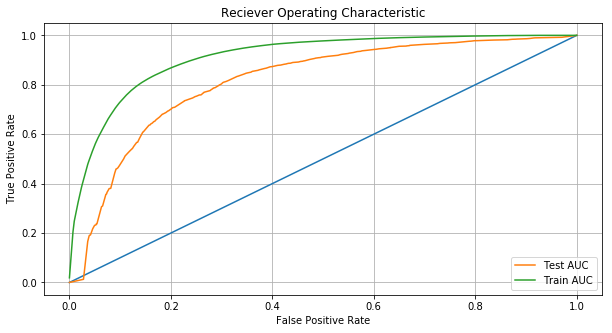

In [89]:
# Plotting ROC AUC curve
plot_roc_curve(Y_test,test_proba,Y_train,train_proba)

## [5.4] Applying Decision Trees on TFIDF W2V,<font color='red'> SET 4</font>

In [90]:
# Splitting list_of_sentance into train and test dataset
from sklearn.cross_validation import train_test_split
Y = final['Score'] # Labels of datapoints
X_train,X_test,Y_train,Y_test = train_test_split(preprocessed_reviews,Y,test_size=0.3,random_state=42)
print(len(X_train))

61441


In [91]:
# Training word2Vec model on traain dataset and will use same for test dataset
w2v_train = []
for sent in X_train:
    w2v_train.append(sent.split())

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(w2v_train,min_count=5,size=100, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('fantastic', 0.7944932579994202), ('awesome', 0.7755023837089539), ('excellent', 0.7472981810569763), ('good', 0.7423273324966431), ('wonderful', 0.7086248397827148), ('terrific', 0.700701117515564), ('amazing', 0.683533787727356), ('perfect', 0.6592554450035095), ('fabulous', 0.6214240789413452), ('decent', 0.5951682925224304)]
[('greatest', 0.8035999536514282), ('best', 0.6831767559051514), ('tastiest', 0.6640757322311401), ('disgusting', 0.6217730641365051), ('nastiest', 0.6159191131591797), ('closest', 0.6119436025619507), ('experienced', 0.6066641807556152), ('horrible', 0.5979635715484619), ('smoothest', 0.5898528695106506), ('worse', 0.5795044302940369)]


In [92]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  14819
sample words  ['pts', 'rustling', 'cotton', 'phenomenon', 'menadione', 'vegetarian', 'comprised', 'ramune', 'alternatives', 'alertness', 'ins', 'honeydew', 'oversight', 'shelter', 'bare', 'crashes', 'hopes', 'minicongos', 'bang', 'efficiently', 'frappes', 'operate', 'ribbons', 'vomit', 'decorative', 'success', 'escaping', 'teapot', 'saw', 'raisen', 'protected', 'illegal', 'bicarbonate', 'wave', 'snip', 'schmidt', 'froth', 'bored', 'mist', 'slits', 'turnip', 'bones', 'dents', 'tangy', 'bay', 'elsewhere', 'molars', 'must', 'expresso', 'insanity']


In [93]:
# Fitting on train and will use same for test to prevent data leakage
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [94]:
train_data = []
for sent in X_train:
    train_data.append(sent.split())

In [95]:
test_data = []
for sent in X_test:
    test_data.append(sent.split())

In [96]:
# TF-IDF weighted Word2Vec for train dataset
train_tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

train_tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(train_data): # for each review/sentence 
    sent_vec = np.zeros(100) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            if word in w2v_words and word in train_tfidf_feat:
                vec = w2v_model.wv[word]
                #tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
                # to reduce the computation we are 
                # dictionary[word] = idf value of word in whole courpus
                # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += 1
        except:
            pass
    if weight_sum != 0:
        sent_vec /= weight_sum
    train_tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 61441/61441 [35:57<00:00, 28.48it/s]  


In [97]:
# TF-IDF weighted Word2Vec for test dataset
test_tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

test_tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(test_data): # for each review/sentence 
    sent_vec = np.zeros(100) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            if word in w2v_words and word in test_tfidf_feat:
                vec = w2v_model.wv[word]
                #tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
                # to reduce the computation we are 
                # dictionary[word] = idf value of word in whole courpus
                # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += 1
        except:
            pass
    if weight_sum != 0:
        sent_vec /= weight_sum
    test_tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 26332/26332 [15:05<00:00, 29.07it/s]


In [98]:
# To find train AUC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score

i=0 # To keep count of row in Auc_mat.
j=0 # To keep count of col in Auc_mat.
for k in depth:
    j=0 # For each row initialize the col to zero. and then it will get increased with each iteration.
    for s in splits:
        clf = DecisionTreeClassifier(max_depth= k,min_samples_split=s)
    
        # Trainig our model
        clf.fit(train_tfidf_sent_vectors,Y_train)
    
        predict_probab = clf.predict_proba(train_tfidf_sent_vectors)[:,1] # Returns probability for positive class only
    
        auc = roc_auc_score(Y_train,predict_probab)
        train_auc_mat[i][j] = auc
        j = j+1  # Increase col number in each iter.
    
    i = i+1 # Increment the row number once each splits is checked for a particular depth

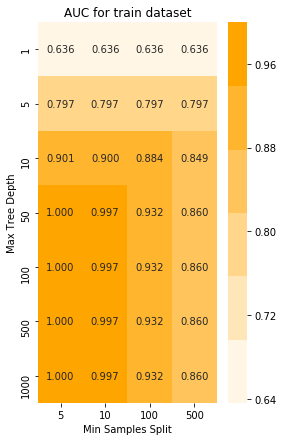

In [99]:
# Printing plot for AUC for train dataset.
plot_train_auc_heatmap(train_auc_mat)

In [100]:
# We will do time based splitting and do 5 fold cross validation 
# This is done as reviews keeps changing with time and hence time based splitting is required

from sklearn.model_selection import TimeSeriesSplit
# Time series object
tscv = TimeSeriesSplit(n_splits=5)

m=0 # To keep count of row in Auc_mat.
n=0 # To keep count of col in Auc_mat.
for k in depth:
    n=0
    for s in splits:
        # Decision Tree classifier
        clf = DecisionTreeClassifier(max_depth= k,min_samples_split=s)
        i=0
        auc=0.0
        for train_index,test_index in tscv.split(train_tfidf_sent_vectors):
            x_train = train_tfidf_sent_vectors[0:train_index[-1]][:] # row 0 to train_index(excluding)
            y_train = Y_train[0:train_index[-1]][:] # row 0 to train_index(excluding)
            x_test = train_tfidf_sent_vectors[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
            y_test = Y_train[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
    
            clf.fit(x_train,y_train)
    
            predict_probab = clf.predict_proba(x_test)[:,1] # returns probability for positive points
            i += 1
            auc += roc_auc_score(y_test,predict_probab)
            
        test_auc_mat[m][n] = auc/i
        n = n+1 # Increment col number.
        
    m = m+1 # Increment row number
        

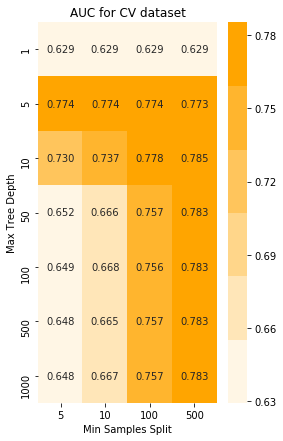

In [101]:
# Printing plot for AUC for test dataset.
plot_cv_auc_heatmap(test_auc_mat)

<h3>Using Grid Search CV</h3>

In [102]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score

# Selecting the estimator . Estimator is the model that you will use to train your model
# We will pass this instance to GridSearchCV
clf = DecisionTreeClassifier()
# Dictionary of parameters to be searched on 
parameters = {'max_depth':depth,'min_samples_split':splits}

# Value on which model will be evaluated
auc_score = make_scorer(roc_auc_score)

# Calling GridSearchCV .
grid_model = GridSearchCV(estimator = clf,param_grid=parameters,cv=3,refit=True,scoring=auc_score,n_jobs=-1)

# Training the gridsearchcv instance
grid_model.fit(train_tfidf_sent_vectors,Y_train)

# this gives the best model with best hyper parameter
optimized_clf = grid_model.best_estimator_
#best_parameters = optimized_clf.best_params_
#best_split = grid_model.best_estimator_.min_samples_split

predict_probab = optimized_clf.predict_proba(test_tfidf_sent_vectors)[:,1] # returns probability of positive points
#predict_y_test = optimized_clf.predict(test_tfidf_sent_vectors)
#predict_y_train = optimized_clf.predict(train_tfidf_sent_vectors)

auc = roc_auc_score(Y_test,predict_probab)
print("The optimized model is",optimized_clf)
print("Auc of best model is",auc)
print("Best Parameters are",grid_model.best_params_)

The optimized model is DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=500,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
Auc of best model is 0.6742410774602691
Best Parameters are {'min_samples_split': 10, 'max_depth': 500}


In [103]:
# Now training model on the hyper parameter which gave best AUC
tree4 = DecisionTreeClassifier(max_depth=50,min_samples_split=500)
tree4.fit(train_tfidf_sent_vectors,Y_train)

# predict class for train dataset
train_y_predict = tree4.predict(train_tfidf_sent_vectors)
# Predict class for test dataset
test_y_predict = tree4.predict(test_tfidf_sent_vectors)

# class probability for train dataset
train_proba = tree4.predict_proba(train_tfidf_sent_vectors)[:,1] # returns probability for positive class
# Class probability for test dataset
test_proba = tree4.predict_proba(test_tfidf_sent_vectors)[:,1] # returns probability for positive class
print("AUC of Tfidf weighted Avg W2V vectorized Decision Tree Classifier is {:.3f}".format(roc_auc_score(Y_test,test_proba)))

AUC of Tfidf weighted Avg W2V vectorized Decision Tree Classifier is 0.803


Confusion Matrix for test data


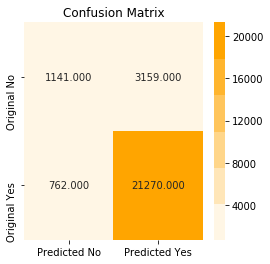

In [104]:
# Plotting confusion matrix
print("Confusion Matrix for test data")
confusion_matrix_plot(Y_test,test_y_predict)

Confusion Matrix for train data


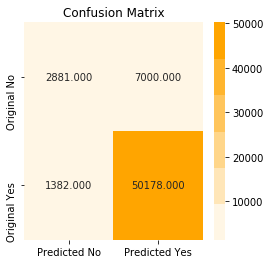

In [105]:
# Plotting confusion matrix
print("Confusion Matrix for train data")
confusion_matrix_plot(Y_train,train_y_predict)

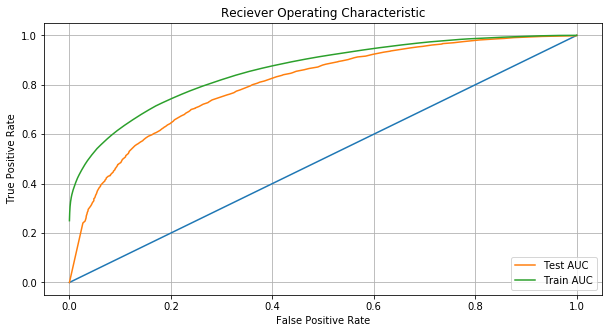

In [106]:
# Plotting ROC AUC curve
plot_roc_curve(Y_test,test_proba,Y_train,train_proba)

<h1>Feature Engineering</h1>

<h3>Using review length as a feature</h3>

In [107]:
# Performing feature engineering on bow vectorized on 100k dataset
# Calculating and storing length of each review in train data set, in an numpy array

train_review_len = np.zeros(len(X_train))
i=0
for sent in X_train:
    train_review_len[i] = len(sent)
    i += 1

print(train_review_len.shape)

(61441,)


In [108]:
# Calculating and storing length of each review in train data set, in an numpy array

test_review_len = np.zeros(len(X_test))
i=0
for sent in X_test:
    test_review_len[i] = len(sent)
    i += 1

print(test_review_len.shape)

(26332,)


In [109]:
# vectorizing train and test dataset using bow
bow_vect = CountVectorizer()
bow_train_vect = bow_vect.fit_transform(X_train)
bow_test_vect = bow_vect.transform(X_test)

In [110]:
print(bow_train_vect.shape)

(61441, 46115)


In [111]:
from scipy.sparse import hstack
from scipy.sparse import coo_matrix
from scipy.sparse import csr_matrix

# now we will add review length as a new feature to train  data set
# The shape of train_review_len is 254919 and hstack takes compatible matrices only 
# Making the train_review_len to bow_train_vect
A = coo_matrix([train_review_len]).T

bow_train_vect = hstack([bow_train_vect,A])
print(bow_train_vect.shape)

(61441, 46116)


In [112]:
# now we will add review length as a new feature to train  data set
# Since hstack takes compatible matrices only 
# Making the test_review_len to bow_test_vect
B = coo_matrix([test_review_len]).T
bow_test_vect = hstack([bow_test_vect,B])
print(bow_test_vect.shape)

(26332, 46116)


In [113]:
from scipy import sparse
# Converting bow_train_vect from scipy.sparse.coo.coo_matrix to scipy.sparse.csr.csr_matrix as 
# scipy.sparse.coo.coo_matrix are not subscriptable

bow_train_vect = sparse.csr_matrix(bow_train_vect)
print(type(bow_train_vect))

<class 'scipy.sparse.csr.csr_matrix'>


In [114]:
# Doing same as above for test dataset
bow_test_vect = sparse.csr_matrix(bow_test_vect)
print(type(bow_test_vect))

<class 'scipy.sparse.csr.csr_matrix'>


In [115]:
from sklearn.preprocessing import StandardScaler
# Initializing standard scaler
std = StandardScaler(with_mean=False)
bow_train_vect = std.fit_transform(bow_train_vect)
bow_test_vect = std.transform(bow_test_vect)

In [116]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score


i=0 # To keep count of row in Auc_mat.
j=0 # To keep count of col in Auc_mat.
for k in depth:
    j=0 # For each row initialize the col to zero. and then it will get increased with each iteration.
    for s in splits:
        clf = DecisionTreeClassifier(max_depth= k,min_samples_split=s)
    
        # Trainig our model
        clf.fit(bow_train_vect,Y_train)
    
        predict_probab = clf.predict_proba(bow_train_vect)[:,1] # Returns probability for positive class only
    
        auc = roc_auc_score(Y_train,predict_probab)
        train_auc_mat[i][j] = auc
        j = j+1  # Increase col number in each iter.
    
    i = i+1 # Increment the row number once each splits is checked for a particular depth
    

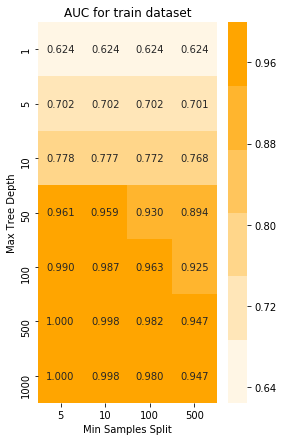

In [117]:
# Printing plot for AUC for train dataset.
plot_train_auc_heatmap(train_auc_mat)

In [118]:
# We will do time based splitting and do 5 fold cross validation 
# This is done as reviews keeps changing with time and hence time based splitting is required

from sklearn.model_selection import TimeSeriesSplit
# Time series object
tscv = TimeSeriesSplit(n_splits=5)

m=0 # To keep count of row in Auc_mat.
n=0 # To keep count of col in Auc_mat.
for k in tqdm(depth):
    n=0
    for s in splits:
        # Decision Tree classifier
        clf = DecisionTreeClassifier(max_depth= k,min_samples_split=s)
        i=0
        auc=0.0
        for train_index,test_index in tscv.split(bow_train_vect):
            x_train = bow_train_vect[0:train_index[-1]][:] # row 0 to train_index(excluding)
            y_train = Y_train[0:train_index[-1]][:] # row 0 to train_index(excluding)
            x_test = bow_train_vect[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
            y_test = Y_train[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
    
            clf.fit(x_train,y_train)
    
            predict_probab = clf.predict_proba(x_test)[:,1] # returns probability for positive points
            i += 1
            auc += roc_auc_score(y_test,predict_probab)
            
        test_auc_mat[m][n] = auc/i
        n = n+1 # Increment col number.
        
    m = m+1 # Increment row number
        
        

100%|██████████| 7/7 [20:47<00:00, 238.76s/it]


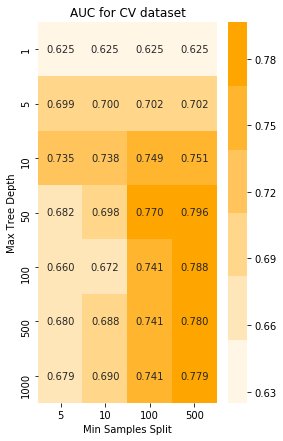

In [119]:
# Printing plot for AUC for test dataset.
plot_cv_auc_heatmap(test_auc_mat)

<h3>Using Grid Search</h3>

In [120]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score

# Selecting the estimator . Estimator is the model that you will use to train your model
# We will pass this instance to GridSearchCV
clf = DecisionTreeClassifier(class_weight="balanced")
# Dictionary of parameters to be searched on 
parameters = {'max_depth':depth,'min_samples_split':splits}

# Value on which model will be evaluated
auc_score = make_scorer(roc_auc_score)

# Calling GridSearchCV .
grid_model = GridSearchCV(estimator = clf,param_grid=parameters,cv=3,refit=True,scoring=auc_score,n_jobs=-1)

# Training the gridsearchcv instance
grid_model.fit(bow_train_vect,Y_train)

# this gives the best model with best hyper parameter
optimized_clf = grid_model.best_estimator_
#best_parameters = optimized_clf.best_params_
#best_split = grid_model.best_estimator_.min_samples_split

predict_probab = optimized_clf.predict_proba(bow_test_vect)[:,1] # returns probability of positive points
predict_y_test = optimized_clf.predict(bow_test_vect)
predict_y_train = optimized_clf.predict(bow_train_vect)

auc = roc_auc_score(Y_test,predict_probab)
print("The optimized model is",optimized_clf)
print("Auc of best model is",auc)

The optimized model is DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=50, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=500,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
Auc of best model is 0.8104080322912972


In [121]:
# Now training model on the hyper parameter which gave best AUC
tree1 = DecisionTreeClassifier(max_depth=50,min_samples_split=500)
tree1.fit(bow_train_vect,Y_train)

# predict class for train dataset
train_y_predict = tree1.predict(bow_train_vect)
# Predict class for test dataset
test_y_predict = tree1.predict(bow_test_vect)

# class probability for train dataset
train_proba = tree1.predict_proba(bow_train_vect)[:,1] # returns probability for positive class
# Class probability for test dataset
test_proba = tree1.predict_proba(bow_test_vect)[:,1] # returns probability for positive class
print("AUC of Bow vectorized Decision Tree Classifier is {:.3f}".format(roc_auc_score(Y_test,test_proba)))

AUC of Bow vectorized Decision Tree Classifier is 0.834


Confusion Matrix for test data


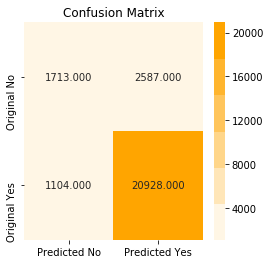

In [122]:
# Plotting confusion matrix
print("Confusion Matrix for test data")
confusion_matrix_plot(Y_test,test_y_predict)

Confusion Matrix for train data


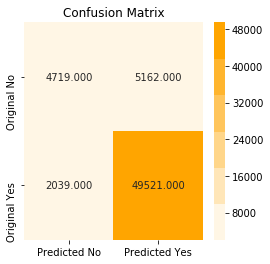

In [123]:
# Plotting confusion matrix
print("Confusion Matrix for train data")
confusion_matrix_plot(Y_train,train_y_predict)

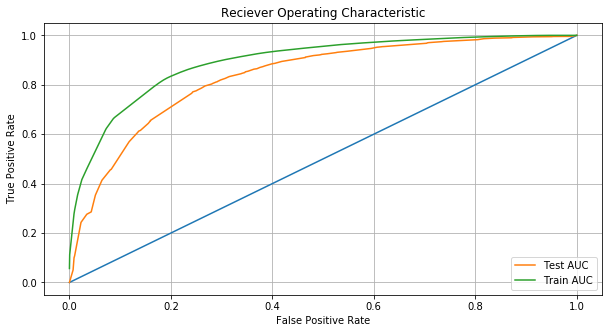

In [124]:
# Plotting ROC AUC curve
plot_roc_curve(Y_test,test_proba,Y_train,train_proba)

<h3>Using review summary as a feature</h3>

In [125]:
# Splitting summary into train and test 
X_train,X_test,Y_train,Y_test = train_test_split(preprocessed_reviews,Y,test_size=0.3,random_state=42)
train_summ,test_summ,Y_train_summ,Y_test_summ = train_test_split(preprocessed_summary,Y,test_size=0.3,random_state=42)

In [126]:
# For reviews train and test dataset
count_vect = CountVectorizer()
# For train dataset
bow_train_vect = count_vect.fit_transform(X_train)
print(bow_train_vect.shape)

# For test dataset
bow_test_vect = count_vect.transform(X_test)
print(bow_test_vect.shape)

(61441, 46115)
(26332, 46115)


In [127]:
# Using bag of words to vectorize summary
# For train dataset
count_vect = CountVectorizer()
# For train dataset
train_vect = count_vect.fit_transform(train_summ)
print(train_vect.shape)

# for test dataset
test_vect = count_vect.transform(test_summ)
print(test_vect.shape)

(61441, 12239)
(26332, 12239)


In [128]:
# now we will add vectorized review as a new feature to train  data set
bow_train_vect = hstack([bow_train_vect,train_vect])
print(bow_train_vect.shape)

(61441, 58354)


In [129]:
# now we will add vectorized review as a new feature to train  data set
bow_test_vect = hstack([bow_test_vect,test_vect])
print(bow_test_vect.shape)

(26332, 58354)


In [130]:
# Converting bow_train_vect and bow_test_vect from scipy.sparse.coo.coo_matrix to scipy.sparse.csr.csr_matrix as 
# scipy.sparse.coo.coo_matrix are not subscriptable

bow_train_vect = sparse.csr_matrix(bow_train_vect)
bow_test_vect = sparse.csr_matrix(bow_test_vect)
print(type(bow_train_vect))
print(type(bow_test_vect))

<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>


In [131]:
# Standarizing data
from sklearn.preprocessing import StandardScaler
std = StandardScaler(with_mean=False)
bow_train_vect = std.fit_transform(bow_train_vect)
bow_test_vect = std.transform(bow_test_vect)

In [132]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score


i=0 # To keep count of row in Auc_mat.
j=0 # To keep count of col in Auc_mat.
for k in depth:
    j=0 # For each row initialize the col to zero. and then it will get increased with each iteration.
    for s in splits:
        clf = DecisionTreeClassifier(max_depth= k,min_samples_split=s)
    
        # Trainig our model
        clf.fit(bow_train_vect,Y_train)
    
        predict_probab = clf.predict_proba(bow_train_vect)[:,1] # Returns probability for positive class only
    
        auc = roc_auc_score(Y_train,predict_probab)
        train_auc_mat[i][j] = auc
        j = j+1  # Increase col number in each iter.
    
    i = i+1 # Increment the row number once each splits is checked for a particular depth
    

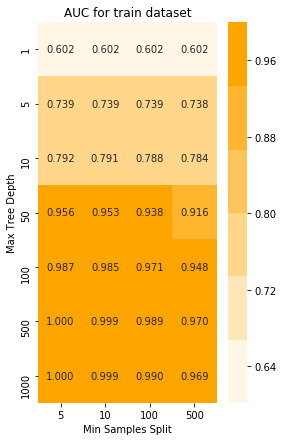

In [133]:
# Printing plot for AUC for train dataset.
plot_train_auc_heatmap(train_auc_mat)

In [134]:
# We will do time based splitting and do 5 fold cross validation 
# This is done as reviews keeps changing with time and hence time based splitting is required

from sklearn.model_selection import TimeSeriesSplit
# Time series object
tscv = TimeSeriesSplit(n_splits=5)

m=0 # To keep count of row in Auc_mat.
n=0 # To keep count of col in Auc_mat.
for k in depth:
    n=0
    for s in splits:
        # Decision Tree classifier
        clf = DecisionTreeClassifier(max_depth= k,min_samples_split=s)
        i=0
        auc=0.0
        for train_index,test_index in tscv.split(bow_train_vect):
            x_train = bow_train_vect[0:train_index[-1]][:] # row 0 to train_index(excluding)
            y_train = Y_train[0:train_index[-1]][:] # row 0 to train_index(excluding)
            x_test = bow_train_vect[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
            y_test = Y_train[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
    
            clf.fit(x_train,y_train)
    
            predict_probab = clf.predict_proba(x_test)[:,1] # returns probability for positive points
            i += 1
            auc += roc_auc_score(y_test,predict_probab)
            
        test_auc_mat[m][n] = auc/i
        n = n+1 # Increment col number.
        
    m = m+1 # Increment row number
        
        

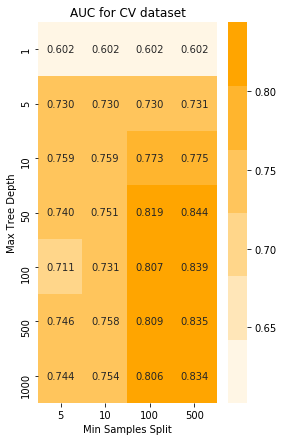

In [135]:
# Printing plot for AUC for test dataset.
plot_cv_auc_heatmap(test_auc_mat)

<h3>Using Grid Search</h3>

In [136]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score

# Selecting the estimator . Estimator is the model that you will use to train your model
# We will pass this instance to GridSearchCV
clf = DecisionTreeClassifier(class_weight="balanced")
# Dictionary of parameters to be searched on 
parameters = {'max_depth':depth,'min_samples_split':splits}

# Value on which model will be evaluated
auc_score = make_scorer(roc_auc_score)

# Calling GridSearchCV .
grid_model = GridSearchCV(estimator = clf,param_grid=parameters,cv=3,refit=True,scoring=auc_score,n_jobs=-1)

# Training the gridsearchcv instance
grid_model.fit(bow_train_vect,Y_train)

# this gives the best model with best hyper parameter
optimized_clf = grid_model.best_estimator_
#best_parameters = optimized_clf.best_params_
#best_split = grid_model.best_estimator_.min_samples_split

predict_probab = optimized_clf.predict_proba(bow_test_vect)[:,1] # returns probability of positive points
predict_y_test = optimized_clf.predict(bow_test_vect)
predict_y_train = optimized_clf.predict(bow_train_vect)

auc = roc_auc_score(Y_test,predict_probab)
print("The optimized model is",optimized_clf)
print("Auc of best model is",auc)

The optimized model is DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=50, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=500,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
Auc of best model is 0.8675442168684874


In [137]:
# Now training model on the hyper parameter which gave best AUC
tree1 = DecisionTreeClassifier(max_depth=50,min_samples_split=500)
tree1.fit(bow_train_vect,Y_train)

# predict class for train dataset
train_y_predict = tree1.predict(bow_train_vect)
# Predict class for test dataset
test_y_predict = tree1.predict(bow_test_vect)

# class probability for train dataset
train_proba = tree1.predict_proba(bow_train_vect)[:,1] # returns probability for positive class
# Class probability for test dataset
test_proba = tree1.predict_proba(bow_test_vect)[:,1] # returns probability for positive class
print("AUC of Bow vectorized Decision Tree Classifier is {:.3f}".format(roc_auc_score(Y_test,test_proba)))

AUC of Bow vectorized Decision Tree Classifier is 0.864


Confusion Matrix for test data


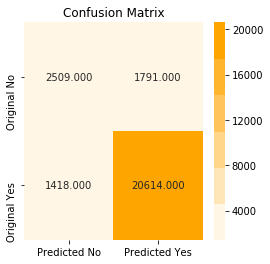

In [138]:
# Plotting confusion matrix
print("Confusion Matrix for test data")
confusion_matrix_plot(Y_test,test_y_predict)

Confusion Matrix for test data


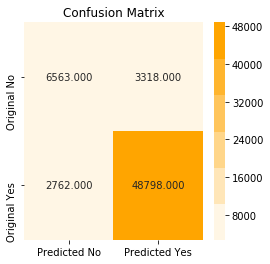

In [139]:
# Plotting confusion matrix
print("Confusion Matrix for test data")
confusion_matrix_plot(Y_train,train_y_predict)

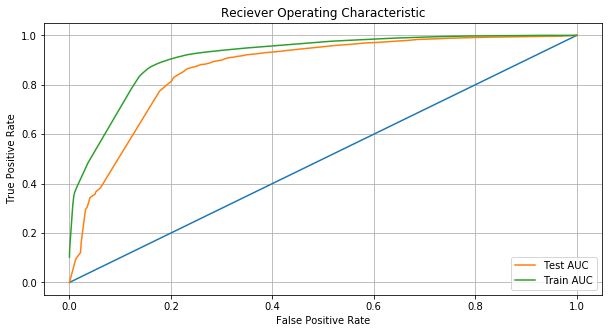

In [140]:
# Plotting ROC AUC curve
plot_roc_curve(Y_test,test_proba,Y_train,train_proba)

# [6] Conclusions

In [1]:
from prettytable import PrettyTable

# Initializing table object
print("For Decision Tree")
x = PrettyTable()

x.field_names = ["Vectorizer","Model","Max Depth","Min Sample Splits","Area Under Curve"]

x.add_row([ "Bow","Decision Tree","50","500","0.834" ])
x.add_row([ "Tfidf","Decision Tree","50","500","0.825" ])
x.add_row([ "AvgW2V","Decision Tree","10","10","0.814" ])
x.add_row([ "Tfidf weighted W2V","Decision Tree","50","500","0.803" ])
x.add_row([ "Bow with review length ","Decision Tree","50","500","0.834" ])
x.add_row([ "Bow with summary feature","Decision Tree","50","500","0.864" ])

print(x)

For Decision Tree
+--------------------------+---------------+-----------+-------------------+------------------+
|        Vectorizer        |     Model     | Max Depth | Min Sample Splits | Area Under Curve |
+--------------------------+---------------+-----------+-------------------+------------------+
|           Bow            | Decision Tree |     50    |        500        |      0.834       |
|          Tfidf           | Decision Tree |     50    |        500        |      0.825       |
|          AvgW2V          | Decision Tree |     10    |         10        |      0.814       |
|    Tfidf weighted W2V    | Decision Tree |     50    |        500        |      0.803       |
| Bow with review length   | Decision Tree |     50    |        500        |      0.834       |
| Bow with summary feature | Decision Tree |     50    |        500        |      0.864       |
+--------------------------+---------------+-----------+-------------------+------------------+


<h2>Explaination </h2>
<h4>Data was cleaned and then we split data into train and test dataset with 70:30 ratio.</h4>
<h4>Train and test dataset were vectorized using fit_transform and transform methods to prevent data lekage.</h4>
<h4>We wrote our own for loops to to hyper parameter tunning by potting the train and cross validation AUC using heatmaps and then selecting the hyper-parameter corresponding to best cross-validation AUC.</h4>
<h4>We have also used GridSearchCV to select best hyper Parameter.</h4>
<h4>We have used graphviz to plot the decision tree but with depth 5 so that visualization becomes easier.</h4>
<h4>We have printed top 20 most important features for bow and tfidf trained decision tree.To print these features we have used feature_importances method and sorted the weights using argsort.</h4>
<h4>We selected features corresponding to last 20 indexeswe got after using argsort.</h4>
<h4>Without feature wngineering the best model was Bow trained decision tree with depth 50 and AUC of 0.834</h4>
<h4>In feature engineering section we have used review length and summary as a feature along with review features.</h4>
<h4>We calculated length of each review and vectorized each sumomary and then combined these with reviews using hstack.</h4>
<h4>When we vectorized review summary using bow and used as a feature our AUC improved from 0.834 to 0.864</h4>
<h4>The best AUC was of model in which we used summary as a feature andit gave an AUC of 0.864</h4>